In [1]:
import pandas as pd
import numpy as np
import json
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
import math
import re
import seaborn as sns
sns.set()

### Files locations

In [2]:
FILE_USERS = "../../data/tweets/raw_users_2019.csv"
FILE_USERS_TWEETS = "../../data/tweets/raw_tweets_2019.csv"

FILE_RETWEETERS = "../../data/retweets/retweets_2019.csv"
FILE_RETWEETERS_USERS = "../../data/retweets/retweets_users_2019.csv"

FINAL_DATASET = "../../data/processed_tweets/tweets_"
FINAL_DATASET_RETWEETS_INFO = "../../data/processed_retweets/retweets_info_"

### Load Datasets

In [3]:
df_users = pd.read_csv(filepath_or_buffer=FILE_USERS, sep=",")
df_tweets = pd.read_csv(filepath_or_buffer=FILE_USERS_TWEETS, sep=",")

# df_users = df_users[:100]
# df_tweets = df_tweets[:100]

C:\Users\Miguel\AppData\Local\Temp\ipykernel_15384\1493569851.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_users = pd.read_csv(filepath_or_buffer=FILE_USERS, sep=",")


In [4]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535027 entries, 0 to 535026
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         535027 non-null  int64 
 1   tweet_id           535027 non-null  int64 
 2   text               535027 non-null  object
 3   user_id            535027 non-null  int64 
 4   timestamp          535027 non-null  object
 5   tweet_type         535027 non-null  object
 6   like_count         535027 non-null  int64 
 7   reply_count        535027 non-null  int64 
 8   retweet_count      535027 non-null  int64 
 9   quote_count        535027 non-null  int64 
 10  device             518149 non-null  object
 11  lang               535027 non-null  object
 12  topics_ids         535027 non-null  object
 13  topics             535027 non-null  object
 14  referenced_tweets  111928 non-null  object
dtypes: int64(7), object(8)
memory usage: 61.2+ MB


### Sort tweets by timestamp

In [5]:
df_tweets = df_tweets.sort_values(by='timestamp', ascending=True).reset_index()
df_tweets.head(5)

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets
0,491246,491246,1079904885246705665,I’ll never salt you down 😌,497001647,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN
1,491248,491248,1079904884445581312,You know who you are; but some of you I’ve fol...,112542289,2019-01-01 00:59:22,Original Tweet,2,0,1,0,iPhone,en,[],[],NaN
2,491247,491247,1079904885175476224,Oh she a freak freak https://t.co/uJqYxJUGgg,2372981097,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN
3,491245,491245,1079904885531791360,Don’t forget your red thong ladies,2446281619,2019-01-01 00:59:23,Original Tweet,2,0,0,0,iPhone,en,[],[],NaN
4,491244,491244,1079904886014107648,Thankful for my crazy life,823355577526931457,2019-01-01 00:59:23,Original Tweet,5,1,0,0,iPhone,en,[],[],NaN


### Delete duplicate users

In [6]:
df_users = df_users.drop_duplicates(subset=['user_id'], keep="first")
df_users

,Unnamed: 0,user_id,name,username,followers,following,tweet_count,verified,created_at
0,0,2980798068,Cortisha❤️,_precioso__,16685,7571,49073,False,2015-01-13 22:31:38+00:00
1,1,1042282718,Turki_alotaibi,alotaibi7_turki,278,492,3301,False,2012-12-28 14:06:22+00:00
2,2,2388053407,sag.,xokaysl,1309,1124,62401,False,2014-03-13 23:13:09+00:00
3,3,49823753,Scott,Scott_R_JC,1930,243,51495,False,2009-06-23 00:23:14+00:00
4,4,37273992,Grandpa DCI,buttongod_ks,605,1246,12825,False,2009-05-02 20:21:09+00:00
...,...,...,...,...,...,...,...,...,...
535017,535017,2988093543,529146,_princessdaisha,434,319,13041,False,2015-01-20 22:04:13
535021,535021,964832593,529150,CoachBradLaird,8024,1290,1414,False,2012-11-22 19:27:15
535023,535023,133080207,529152,CodyLaGrow,2917,3903,9771,True,2010-04-15 00:01:24
535025,535025,1003280186115100672,529154,breannathemac_,743,245,7326,False,2018-06-03 14:20:11


## Calculate tweet reach

#### These values indicate the maximum possible of people that could have seen a given tweet

To do this, a sum of all the original tweet user's followers is made with the followers from all the users that retweeted/quoted the tweet

Note: this assumes that if a retweet is then shared by retweet again, those next audiences are not taken into account

In [7]:
df_retweeters = pd.read_csv(filepath_or_buffer=FILE_RETWEETERS_USERS, sep=",")
df_retweets = pd.read_csv(filepath_or_buffer=FILE_RETWEETERS, sep=",")

In [8]:
df_retweets.head()

,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets
0,0,1219206225000325121,RT @iamcreans: Hey Twitter! Look who stopped b...,1164218208951373825,2020-01-20 10:33:10,Retweet Tweet,0,0,2,0,Web,en,[],[],"[ReferencedTweet(id: 1210832597544140802, type..."
1,1,1211118455975534593,RT @gormygoesketo: It’s a cliché but it’s true...,788771272121548800,2019-12-29 02:55:16,Retweet Tweet,0,0,4,0,Android,en,[],[],"[ReferencedTweet(id: 1210832629446004737, type..."
2,2,1211055402143498240,"I think you’ve bested him, Mr. Strategy. https...",413547490,2019-12-28 22:44:42,Quote Tweet,3,2,0,0,iPhone,en,[],[],"[ReferencedTweet(id: 1210726852328751104, type..."
3,3,1211034309886267392,RT @iamcreans: Hey Twitter! Look who stopped b...,47093197,2019-12-28 21:20:54,Retweet Tweet,0,0,2,0,iPhone,en,[],[],"[ReferencedTweet(id: 1210832597544140802, type..."
4,4,1210949535528366084,RT @gormygoesketo: It’s a cliché but it’s true...,2920237746,2019-12-28 15:44:02,Retweet Tweet,0,0,4,0,iPhone,en,[],[],"[ReferencedTweet(id: 1210832629446004737, type..."


In [9]:
df_retweeters.head()

,Unnamed: 0,user_id,name,username,followers,following,tweet_count,verified,created_at
0,0,1164218208951373825,Ghost,Ghosthost22,373,4598,29173,False,2019-08-21 16:51:52
1,1,788771272121548800,KetoSimple,KetoSimple,6639,566,20225,False,2016-10-19 15:58:20
2,2,413547490,Andre Meunier,AndreMeunier13,1668,716,7648,True,2011-11-16 00:50:16
3,3,47093197,dean geyer,geyerdean,86895,51,3835,True,2009-06-14 13:42:23
4,4,2920237746,Jason | Carnist | Culinary Minimalist | Humorist,fancypirate8,3321,1386,93809,False,2014-12-06 05:56:29


### Removing duplicated retweeters

37432 retweeters will be removed

In [10]:
df_retweeters.shape

(130721, 9)

In [11]:
df_retweeters = df_retweeters.drop_duplicates(subset=['user_id'], keep="first")
df_retweeters

,Unnamed: 0,user_id,name,username,followers,following,tweet_count,verified,created_at
0,0,1164218208951373825,Ghost,Ghosthost22,373,4598,29173,False,2019-08-21 16:51:52
1,1,788771272121548800,KetoSimple,KetoSimple,6639,566,20225,False,2016-10-19 15:58:20
2,2,413547490,Andre Meunier,AndreMeunier13,1668,716,7648,True,2011-11-16 00:50:16
3,3,47093197,dean geyer,geyerdean,86895,51,3835,True,2009-06-14 13:42:23
4,4,2920237746,Jason | Carnist | Culinary Minimalist | Humorist,fancypirate8,3321,1386,93809,False,2014-12-06 05:56:29
...,...,...,...,...,...,...,...,...,...
130715,130715,819838633,Jay Gray,jaygraymatters,4831,243,12169,True,2012-09-12 15:58:04
130716,130716,869975749725376512,okie,staccatosounds,647,965,28543,False,2017-05-31 17:55:56
130718,130718,944341926,Jim Pedersen,PedersenNBCNC,334,2789,385,False,2012-11-12 18:52:01
130719,130719,52752875,Lisa Respers France,LisaFranceCNN,18075,2094,53035,True,2009-07-01 15:19:53


In [12]:
df_retweets.shape

(130721, 15)

In [13]:
df_retweets = df_retweets.sort_values(by='timestamp', ascending=True).reset_index()
df_retweets.head(5)

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets
0,119570,119570,1079904986971156480,"RT @FaZeClan: January, 2018 https://t.co/bxyyn...",863014342538776577,2019-01-01 00:59:47,Retweet Tweet,0,0,171,0,iPhone,en,[],[],"[ReferencedTweet(id: 1079904942729523200, type..."
1,119569,119569,1079905009767133185,RT @IrwindalePolice: The second group of @Rose...,67143433,2019-01-01 00:59:52,Retweet Tweet,0,0,10,0,iPhone,en,[],[],"[ReferencedTweet(id: 1079904903596666880, type..."
2,119568,119568,1079905092256624642,"RT @FaZeClan: January, 2018 https://t.co/bxyyn...",887062199189078020,2019-01-01 01:00:12,Retweet Tweet,0,0,171,0,iPhone,en,[],[],"[ReferencedTweet(id: 1079904942729523200, type..."
3,119567,119567,1079905147898286080,"RT @FaZeClan: January, 2018 https://t.co/bxyyn...",3069273057,2019-01-01 01:00:25,Retweet Tweet,0,0,171,0,iPhone,en,[],[],"[ReferencedTweet(id: 1079904942729523200, type..."
4,119566,119566,1079905204521250816,"RT @FaZeClan: January, 2018 https://t.co/bxyyn...",996735592275705856,2019-01-01 01:00:39,Retweet Tweet,0,0,171,0,Android,en,[],[],"[ReferencedTweet(id: 1079904942729523200, type..."


### Merge retweets datasets

In [14]:
df_retweets_info = pd.merge(df_retweets[['tweet_id', 'user_id', 'topics', 'referenced_tweets']], df_retweeters[['user_id', 'followers', 'following']], how='left', on="user_id")
df_retweets_info.head(5)

,tweet_id,user_id,topics,referenced_tweets,followers,following
0,1079904986971156480,863014342538776577,[],"[ReferencedTweet(id: 1079904942729523200, type...",2589,4948
1,1079905009767133185,67143433,[],"[ReferencedTweet(id: 1079904903596666880, type...",20384,7487
2,1079905092256624642,887062199189078020,[],"[ReferencedTweet(id: 1079904942729523200, type...",26,89
3,1079905147898286080,3069273057,[],"[ReferencedTweet(id: 1079904942729523200, type...",262,873
4,1079905204521250816,996735592275705856,[],"[ReferencedTweet(id: 1079904942729523200, type...",14,140


### Removing non-direct retweets

When colecting the retweets some tweets that mencioned the url of the original tweet and because of that were also collected as "retweets".
Since this tipe of tweets don't count to the retweet count of the original tweet and they only represent 0,0012% of the retweets collected they will be removed

In [15]:
df_retweets_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130721 entries, 0 to 130720
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet_id           130721 non-null  int64 
 1   user_id            130721 non-null  int64 
 2   topics             130721 non-null  object
 3   referenced_tweets  130596 non-null  object
 4   followers          130721 non-null  int64 
 5   following          130721 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 7.0+ MB


In [16]:
df_retweets_info[pd.isna(df_retweets_info['referenced_tweets'])]

,tweet_id,user_id,topics,referenced_tweets,followers,following
3354,1085263768249032705,984950633349328896,[],NaN,1285,678
3488,1085592552034787328,1060606895231246337,[],NaN,1,0
3598,1085904582469959680,483366086,[],NaN,4259,967
3804,1086540572293091328,16367986,[],NaN,3954,4883
4652,1087033225741041665,250166431,[],NaN,118549,1377
...,...,...,...,...,...,...
128065,1210927024627425280,971405560439627777,[],NaN,21,5
128299,1211363436627734529,27082165,[],NaN,1089,3192
129248,1214195378133667841,2249186514,[],NaN,122,1008
129724,1274227212628131841,103676360,[],NaN,811,1445


In [17]:
df_retweets[df_retweets['tweet_id'] == 1213652399782604806]['text']

Series([], Name: text, dtype: object)

In [18]:
df_retweets_info = df_retweets_info[df_retweets_info['referenced_tweets'].notna()]

In [19]:
def get_ref_tweet_id(ref_tweets):
    g = str(ref_tweets)
    if isinstance(g, str) and g != 'nan' and not pd.isna(g):
        return int(g.split()[1].replace(',', ''))
    else: return None

In [20]:
df_retweets_info['ref_tweed_id'] = [get_ref_tweet_id(ref_tweet) for ref_tweet in df_retweets_info['referenced_tweets']]
df_retweets_info.head()

,tweet_id,user_id,topics,referenced_tweets,followers,following,ref_tweed_id
0,1079904986971156480,863014342538776577,[],"[ReferencedTweet(id: 1079904942729523200, type...",2589,4948,1079904942729523200
1,1079905009767133185,67143433,[],"[ReferencedTweet(id: 1079904903596666880, type...",20384,7487,1079904903596666880
2,1079905092256624642,887062199189078020,[],"[ReferencedTweet(id: 1079904942729523200, type...",26,89,1079904942729523200
3,1079905147898286080,3069273057,[],"[ReferencedTweet(id: 1079904942729523200, type...",262,873,1079904942729523200
4,1079905204521250816,996735592275705856,[],"[ReferencedTweet(id: 1079904942729523200, type...",14,140,1079904942729523200


In [21]:
df_tweets['ref_tweed_id'] = [get_ref_tweet_id(ref_tweet) for ref_tweet in df_tweets['referenced_tweets']]
# converting the reference ids that exist to int
df_tweets['ref_tweed_id'] = pd.to_numeric(df_tweets['ref_tweed_id'], errors='coerce').fillna(0).astype(np.int64)
df_tweets.head()

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets,ref_tweed_id
0,491246,491246,1079904885246705665,I’ll never salt you down 😌,497001647,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN,0
1,491248,491248,1079904884445581312,You know who you are; but some of you I’ve fol...,112542289,2019-01-01 00:59:22,Original Tweet,2,0,1,0,iPhone,en,[],[],NaN,0
2,491247,491247,1079904885175476224,Oh she a freak freak https://t.co/uJqYxJUGgg,2372981097,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN,0
3,491245,491245,1079904885531791360,Don’t forget your red thong ladies,2446281619,2019-01-01 00:59:23,Original Tweet,2,0,0,0,iPhone,en,[],[],NaN,0
4,491244,491244,1079904886014107648,Thankful for my crazy life,823355577526931457,2019-01-01 00:59:23,Original Tweet,5,1,0,0,iPhone,en,[],[],NaN,0


In [22]:
def calculate_tweet_reach(tweet_id, user_id, topics, retweets_count, ref_tweed_id):
    total_reach = 0
    total_reach += df_users[df_users['user_id'] == user_id]['followers'].sum()
    if topics != '[]' and retweets_count > 0:
        if ref_tweed_id is not None and ref_tweed_id != 0:
            total_reach += df_retweets_info[(df_retweets_info['ref_tweed_id'] == tweet_id) | (df_retweets_info['ref_tweed_id'] == ref_tweed_id)]['followers'].sum()
        else:
            total_reach += df_retweets_info[df_retweets_info['ref_tweed_id'] == tweet_id]['followers'].sum()
    return total_reach

In [23]:
df_tweets['reach'] = [calculate_tweet_reach(row[0], row[1], row[2], row[3], row[4]) for row in zip(df_tweets['tweet_id'],                        df_tweets['user_id'], df_tweets['topics'], df_tweets['retweet_count'], df_tweets['ref_tweed_id'])]
df_tweets.head(5)

# faster alternative: # Iterating over multiple columns - differing data type
# result = [f(row[0], ..., row[n]) for row in zip(df['col1'], ..., df['coln'])]

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets,ref_tweed_id,reach
0,491246,491246,1079904885246705665,I’ll never salt you down 😌,497001647,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN,0,1468
1,491248,491248,1079904884445581312,You know who you are; but some of you I’ve fol...,112542289,2019-01-01 00:59:22,Original Tweet,2,0,1,0,iPhone,en,[],[],NaN,0,2969
2,491247,491247,1079904885175476224,Oh she a freak freak https://t.co/uJqYxJUGgg,2372981097,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN,0,809
3,491245,491245,1079904885531791360,Don’t forget your red thong ladies,2446281619,2019-01-01 00:59:23,Original Tweet,2,0,0,0,iPhone,en,[],[],NaN,0,112
4,491244,491244,1079904886014107648,Thankful for my crazy life,823355577526931457,2019-01-01 00:59:23,Original Tweet,5,1,0,0,iPhone,en,[],[],NaN,0,356


## Topic analysis

### Loading the previously trained topic analysis model and it's evaluations of each tweet text

In [24]:
df_tweets.head(5)

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets,ref_tweed_id,reach
0,491246,491246,1079904885246705665,I’ll never salt you down 😌,497001647,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN,0,1468
1,491248,491248,1079904884445581312,You know who you are; but some of you I’ve fol...,112542289,2019-01-01 00:59:22,Original Tweet,2,0,1,0,iPhone,en,[],[],NaN,0,2969
2,491247,491247,1079904885175476224,Oh she a freak freak https://t.co/uJqYxJUGgg,2372981097,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,[],[],NaN,0,809
3,491245,491245,1079904885531791360,Don’t forget your red thong ladies,2446281619,2019-01-01 00:59:23,Original Tweet,2,0,0,0,iPhone,en,[],[],NaN,0,112
4,491244,491244,1079904886014107648,Thankful for my crazy life,823355577526931457,2019-01-01 00:59:23,Original Tweet,5,1,0,0,iPhone,en,[],[],NaN,0,356


In [25]:
def process_topic(topics:str):
    s = topics
    for i in range(topics.count('\'')):
        s = s.replace('\'', '"')
    t = json.loads(s)
    if len(t) > 0:
        return t[0]
    return None

In [26]:
df_tweets['topics'] = [process_topic(topics) for topics in df_tweets['topics']]
df_tweets['topics_ids'] = [process_topic(topics_ids) for topics_ids in df_tweets['topics_ids']]
df_tweets.head(5)

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets,ref_tweed_id,reach
0,491246,491246,1079904885246705665,I’ll never salt you down 😌,497001647,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,None,None,NaN,0,1468
1,491248,491248,1079904884445581312,You know who you are; but some of you I’ve fol...,112542289,2019-01-01 00:59:22,Original Tweet,2,0,1,0,iPhone,en,None,None,NaN,0,2969
2,491247,491247,1079904885175476224,Oh she a freak freak https://t.co/uJqYxJUGgg,2372981097,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,None,None,NaN,0,809
3,491245,491245,1079904885531791360,Don’t forget your red thong ladies,2446281619,2019-01-01 00:59:23,Original Tweet,2,0,0,0,iPhone,en,None,None,NaN,0,112
4,491244,491244,1079904886014107648,Thankful for my crazy life,823355577526931457,2019-01-01 00:59:23,Original Tweet,5,1,0,0,iPhone,en,None,None,NaN,0,356


### Grouping the topics in broader categories

In [27]:
def group_topics(topic):
    if pd.isna(topic):
        return None

    if not isinstance(topic, str):
        print(topic)

    if 'Brand' in topic or 'Product' in topic:
        return 'Brand'
    elif 'Person' in topic:
        return 'Person'
    elif 'Sport' in topic or 'Athlete' in topic or 'Coach' in topic or 'Hockey' in topic or 'Football' in topic or 'NFL' in topic:
        return 'Sport'
    elif 'TV' in topic or 'Movie' in topic or 'Award' in topic or 'Actor' in topic or 'Fictional Character' in topic\
            or 'Entertainment' in topic:
        return 'TV and Movies'
    elif 'Music' in topic or 'Musician' in topic or 'Concert' in topic or 'Song' in topic or 'Radio' in topic:
        return 'Music'
    elif 'Book' in topic:
        return 'Book'
    elif 'Hobbies' in topic:
        return 'Interest and Hobbies'
    elif 'Video Game' in topic or 'Esports' in topic or 'eSport' in topic:
        return 'Video Game'
    elif 'Political' in topic or 'Politicians' in topic:
        return 'Political'
    elif 'Holiday' in topic:
        return 'Holiday'
    elif 'News' in topic:
        return 'News'
    elif 'Entities' in topic:
        return 'Entities'
    else:
        return 'Other'

In [28]:
df_tweets['topics_cleaned'] = [group_topics(topic) for topic in df_tweets['topics']]
df_tweets.head(5)

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets,ref_tweed_id,reach,topics_cleaned
0,491246,491246,1079904885246705665,I’ll never salt you down 😌,497001647,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,None,None,NaN,0,1468,None
1,491248,491248,1079904884445581312,You know who you are; but some of you I’ve fol...,112542289,2019-01-01 00:59:22,Original Tweet,2,0,1,0,iPhone,en,None,None,NaN,0,2969,None
2,491247,491247,1079904885175476224,Oh she a freak freak https://t.co/uJqYxJUGgg,2372981097,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,None,None,NaN,0,809,None
3,491245,491245,1079904885531791360,Don’t forget your red thong ladies,2446281619,2019-01-01 00:59:23,Original Tweet,2,0,0,0,iPhone,en,None,None,NaN,0,112,None
4,491244,491244,1079904886014107648,Thankful for my crazy life,823355577526931457,2019-01-01 00:59:23,Original Tweet,5,1,0,0,iPhone,en,None,None,NaN,0,356,None


### NaNs treatment

In [ ]:
df_tweets['topics_ids'].fillna(value=-1, inplace=True)
df_tweets['topics_ids'] = df_tweets['topics_ids'].apply(lambda x: int(x))
df_tweets['topics'].fillna(value="", inplace=True)

In [29]:
df_tweets['topics_cleaned'].value_counts(normalize=True)

Person                  0.190215
TV and Movies           0.177633
Other                   0.166645
Brand                   0.153665
Interest and Hobbies    0.138305
Entities                0.106647
Sport                   0.037750
Music                   0.010406
Video Game              0.010166
Political               0.007491
Book                    0.001072
Holiday                 0.000005
Name: topics_cleaned, dtype: float64

## Sentiment analysis

In [30]:
sid_obj = SentimentIntensityAnalyzer()

In [31]:
def sentiment_scores(sentence, prints):
    if prints: print("\nSentence:", sentence)

    sentiment_dict = sid_obj.polarity_scores(sentence)

    if sentiment_dict['compound'] >= 0.05:
        if prints: print("Positive")
        return "Positive"
    elif sentiment_dict['compound'] <= - 0.05:
        if prints: print("Positive")
        return "Negative"
    else:
        if prints: print("Neutral")
        return "Neutral"

In [32]:
df_tweets['sentiment'] = [sentiment_scores(tweet_text, False) for tweet_text in df_tweets['text']]

In [33]:
df_tweets.head(5)

,index,Unnamed: 0,tweet_id,text,user_id,timestamp,tweet_type,like_count,reply_count,retweet_count,quote_count,device,lang,topics_ids,topics,referenced_tweets,ref_tweed_id,reach,topics_cleaned,sentiment
0,491246,491246,1079904885246705665,I’ll never salt you down 😌,497001647,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,None,None,NaN,0,1468,None,Positive
1,491248,491248,1079904884445581312,You know who you are; but some of you I’ve fol...,112542289,2019-01-01 00:59:22,Original Tweet,2,0,1,0,iPhone,en,None,None,NaN,0,2969,None,Positive
2,491247,491247,1079904885175476224,Oh she a freak freak https://t.co/uJqYxJUGgg,2372981097,2019-01-01 00:59:22,Original Tweet,0,0,0,0,iPhone,en,None,None,NaN,0,809,None,Negative
3,491245,491245,1079904885531791360,Don’t forget your red thong ladies,2446281619,2019-01-01 00:59:23,Original Tweet,2,0,0,0,iPhone,en,None,None,NaN,0,112,None,Negative
4,491244,491244,1079904886014107648,Thankful for my crazy life,823355577526931457,2019-01-01 00:59:23,Original Tweet,5,1,0,0,iPhone,en,None,None,NaN,0,356,None,Positive


## Hashtags

In [ ]:
def has_hashtags(text):
    return len(re.findall(r'\B#\w*[a-zA-Z]+\w*', text)) > 0

In [ ]:
df_tweets['hashtags'] = [has_hashtags(text) for text in df_tweets['text']]

## Tweet popularity

To define tweet popularity, each tweet with at least 1 retweet or 1 quote tweet was considered popular (1)
if the criteria wasn't met it was marked as unpopular (0)

In [34]:
def tweet_popularity_label(retweet_count, quote_count):
    if retweet_count > 0 or quote_count > 0:
        return 1
    else:
        return 0

In [35]:
df_tweets['popularity'] = [tweet_popularity_label(ret, qou) for ret, qou in zip(df_tweets['retweet_count'],df_tweets['quote_count'])]

In [36]:
df_tweets['popularity'].value_counts(normalize=True)

0    0.800857
1    0.199143
Name: popularity, dtype: float64

## Combine the two datasets into the final one

For every tweet select the relevant columns and merge the corresponding information from the original user

In [37]:
df = pd.merge(df_tweets[['tweet_id', 'text', 'timestamp', 'user_id', 'like_count', 'retweet_count', 'quote_count',
                        'reply_count', 'reach', 'topics_ids', 'topics', 'topics_cleaned', 'sentiment', 'hashtags', 'popularity']],
                        df_users[['user_id', 'followers', 'following', 'tweet_count', 'verified', 'created_at']],
                        on="user_id").reset_index()
df.head(5)

,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,topics_ids,topics,topics_cleaned,sentiment,popularity,followers,following,tweet_count,verified,created_at
0,0,1079904885246705665,I’ll never salt you down 😌,2019-01-01 00:59:22,497001647,0,0,0,0,1468,None,None,None,Positive,0,1468,1043,32941,False,2012-02-19 14:20:44+00:00
1,1,1181478514601672704,I need to go to sleeeeeep,2019-10-08 07:56:43+00:00,497001647,0,0,0,0,1468,None,None,None,Neutral,0,1468,1043,32941,False,2012-02-19 14:20:44+00:00
2,2,1079904884445581312,You know who you are; but some of you I’ve fol...,2019-01-01 00:59:22,112542289,2,1,0,0,2969,None,None,None,Positive,1,2969,2890,137517,False,2010-02-08 21:52:01+00:00
3,3,1083000265597485056,Good morning frens. Don’t think about yesterda...,2019-01-09 13:59:19,112542289,5,1,0,0,2969,None,None,None,Neutral,1,2969,2890,137517,False,2010-02-08 21:52:01+00:00
4,4,1100394993972404224,Have any of you seen that post about the salon...,2019-02-26 13:59:45+00:00,112542289,3,1,0,1,4897,13,Place,Other,Positive,1,2969,2890,137517,False,2010-02-08 21:52:01+00:00


## Process tweets timestamps

In [38]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Categorize by year, month, week days and phases of the day

In [39]:
def get_day_phase(hour):
    if 0 <= hour < 7:
        return "Middle of the night"
    elif 7 <= hour < 13:
        return "Morning"
    elif 13 <= hour < 16:
        return "Afternoon"
    elif 16 <= hour < 20:
        return "Dusk"
    elif 20 <= hour < 24:
        return "Night"

In [40]:
df['year'] = df['timestamp'].apply(lambda x: x.year)
df['month'] = df['timestamp'].apply(lambda x: x.strftime('%B'))
df['day_of_week'] = df['timestamp'].apply(lambda x: x.strftime('%A'))
df['day_phase'] = df['timestamp'].apply(lambda x: get_day_phase(int(x.hour)))
df['week_idx'] = df['timestamp'].apply(lambda x: '%s-%s' % (x.year, '{:02d}'.format(x.isocalendar()[1])))
df

,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,followers,following,tweet_count,verified,created_at,year,month,day_of_week,day_phase,week_idx
0,0,1079904885246705665,I’ll never salt you down 😌,2019-01-01 00:59:22,497001647,0,0,0,0,1468,...,1468,1043,32941,False,2012-02-19 14:20:44+00:00,2019,January,Tuesday,Middle of the night,2019-01
1,1,1181478514601672704,I need to go to sleeeeeep,2019-10-08 07:56:43+00:00,497001647,0,0,0,0,1468,...,1468,1043,32941,False,2012-02-19 14:20:44+00:00,2019,October,Tuesday,Morning,2019-41
2,2,1079904884445581312,You know who you are; but some of you I’ve fol...,2019-01-01 00:59:22,112542289,2,1,0,0,2969,...,2969,2890,137517,False,2010-02-08 21:52:01+00:00,2019,January,Tuesday,Middle of the night,2019-01
3,3,1083000265597485056,Good morning frens. Don’t think about yesterda...,2019-01-09 13:59:19,112542289,5,1,0,0,2969,...,2969,2890,137517,False,2010-02-08 21:52:01+00:00,2019,January,Wednesday,Afternoon,2019-02
4,4,1100394993972404224,Have any of you seen that post about the salon...,2019-02-26 13:59:45+00:00,112542289,3,1,0,1,4897,...,2969,2890,137517,False,2010-02-08 21:52:01+00:00,2019,February,Tuesday,Afternoon,2019-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535022,535022,1212131305615511554,It’s taken almost 20 years.... but the boys ap...,2019-12-31 21:59:58+00:00,3160522828,62,3,1,8,5864,...,5864,1781,24440,False,2015-04-12 16:48:40+00:00,2019,December,Tuesday,Night,2019-01
535023,535023,1212131306085244928,My boss is boss. https://t.co/aButy11GXA,2019-12-31 21:59:58+00:00,802746211,1,0,0,0,681,...,681,1347,63,False,2012-09-04 16:26:43+00:00,2019,December,Tuesday,Night,2019-01
535024,535024,1212131307162988544,Mood: https://t.co/d5iIJatvZO,2019-12-31 21:59:58+00:00,713174863,19,2,0,0,1455,...,1455,157,979,False,2012-07-23 21:42:33+00:00,2019,December,Tuesday,Night,2019-01
535025,535025,1212131308010430464,I’m watching Star Wars for the first time.,2019-12-31 21:59:58+00:00,2463021749,0,0,0,1,1171,...,1171,669,22251,False,2014-04-05 18:53:06+00:00,2019,December,Tuesday,Night,2019-01


In [41]:
cols_to_transform = ['day_phase', 'day_of_week', 'month', 'year', 'sentiment', 'verified']

for col in cols_to_transform:
    enc = LabelEncoder()
    enc.fit(df[col])
    df[col + '_enc'] = enc.transform(df[col])

# Day phase: Dawn -> 1 | Morning -> 3 | Afternoon -> 0 | Evening -> 2 | Night -> 4

# Days of the week:
#   Monday -> 1 | Tuesday -> 5 | Wednesday -> 6
#   Thursday -> 4 | Friday -> 0 | Saturday -> 2 | Sunday -> 3

# Months
#   January -> 4 | February -> 3 | March -> 7 | April -> 0
#   May -> 8 | June -> 6 | July -> 5 | August -> 1
#   September -> 11 | October -> 10 | November -> 9 | December -> 2

# Years
#   2020 -> 0 | 2021 -> 1

# Sentiment
#  Negative -> 0 | Neutral -> 1 | Positive -> 2

# Verified
#  False -> 0 | True -> 1

df.head(5)

,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,month,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc
0,0,1079904885246705665,I’ll never salt you down 😌,2019-01-01 00:59:22,497001647,0,0,0,0,1468,...,January,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0
1,1,1181478514601672704,I need to go to sleeeeeep,2019-10-08 07:56:43+00:00,497001647,0,0,0,0,1468,...,October,Tuesday,Morning,2019-41,3,5,10,0,1,0
2,2,1079904884445581312,You know who you are; but some of you I’ve fol...,2019-01-01 00:59:22,112542289,2,1,0,0,2969,...,January,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0
3,3,1083000265597485056,Good morning frens. Don’t think about yesterda...,2019-01-09 13:59:19,112542289,5,1,0,0,2969,...,January,Wednesday,Afternoon,2019-02,0,6,4,0,1,0
4,4,1100394993972404224,Have any of you seen that post about the salon...,2019-02-26 13:59:45+00:00,112542289,3,1,0,1,4897,...,February,Tuesday,Afternoon,2019-09,0,5,3,0,2,0


### Calculate users seniority

In [42]:
df['created_at'] = pd.to_datetime(df['created_at'], utc=True).dt.strftime("%Y-%m-%d")
df['created_at'] = pd.to_datetime(df['created_at'])
df['seniority'] = df['created_at'].apply(lambda x: relativedelta(datetime.datetime.now(), x).years)

In [43]:
df

,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,1079904885246705665,I’ll never salt you down 😌,2019-01-01 00:59:22,497001647,0,0,0,0,1468,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,10
1,1,1181478514601672704,I need to go to sleeeeeep,2019-10-08 07:56:43+00:00,497001647,0,0,0,0,1468,...,Tuesday,Morning,2019-41,3,5,10,0,1,0,10
2,2,1079904884445581312,You know who you are; but some of you I’ve fol...,2019-01-01 00:59:22,112542289,2,1,0,0,2969,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,12
3,3,1083000265597485056,Good morning frens. Don’t think about yesterda...,2019-01-09 13:59:19,112542289,5,1,0,0,2969,...,Wednesday,Afternoon,2019-02,0,6,4,0,1,0,12
4,4,1100394993972404224,Have any of you seen that post about the salon...,2019-02-26 13:59:45+00:00,112542289,3,1,0,1,4897,...,Tuesday,Afternoon,2019-09,0,5,3,0,2,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535022,535022,1212131305615511554,It’s taken almost 20 years.... but the boys ap...,2019-12-31 21:59:58+00:00,3160522828,62,3,1,8,5864,...,Tuesday,Night,2019-01,4,5,2,0,2,0,7
535023,535023,1212131306085244928,My boss is boss. https://t.co/aButy11GXA,2019-12-31 21:59:58+00:00,802746211,1,0,0,0,681,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535024,535024,1212131307162988544,Mood: https://t.co/d5iIJatvZO,2019-12-31 21:59:58+00:00,713174863,19,2,0,0,1455,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535025,535025,1212131308010430464,I’m watching Star Wars for the first time.,2019-12-31 21:59:58+00:00,2463021749,0,0,0,1,1171,...,Tuesday,Night,2019-01,4,5,2,0,0,0,8


## Outliers

In [44]:
def boxplots(df, cols):
    fig, axes = plt.subplots(2, math.ceil(len(cols) / 2), figsize=(28, 15))
    for ax, feat in zip(axes.flatten(), cols):
        sns.boxplot(x=df[feat], ax=ax, color='steelblue')
    title = "Variables' Box Plots"
    plt.suptitle(title, y=0.95, fontsize=20)
    plt.show()

In [45]:
def outliers_removal(df, outliers_filter):
    df_no_outliers = df[outliers_filter].copy()
    print('Percentage of data kept after removing outliers:', np.round(df_no_outliers.shape[0] / df.shape[0], 4) * 100,
          '%')
    print('Percentage of data removed:', np.round((1 - (df_no_outliers.shape[0] / df.shape[0])) * 100, 4), '%')
    print("Size after outlier removal:", df_no_outliers.shape[0])
    df_rets = df[df['retweet_count'] > 0]
    df_rets_out = df_no_outliers[df_no_outliers['retweet_count'] > 0]
    print("N. of tweets with atleast 1 retweet:", df_no_outliers[df_no_outliers['retweet_count'] > 0].shape[0])
    print('Percentage of tweets with atleast 1 retweet removed:',
          np.round((1 - (df_rets_out.shape[0] / df_rets.shape[0])) * 100, 4), '%')
    return df_no_outliers

In [46]:
var_outliers = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'popularity', 'followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
var_outliers_imp = ['like_count', 'retweet_count', 'followers', 'following', 'seniority']

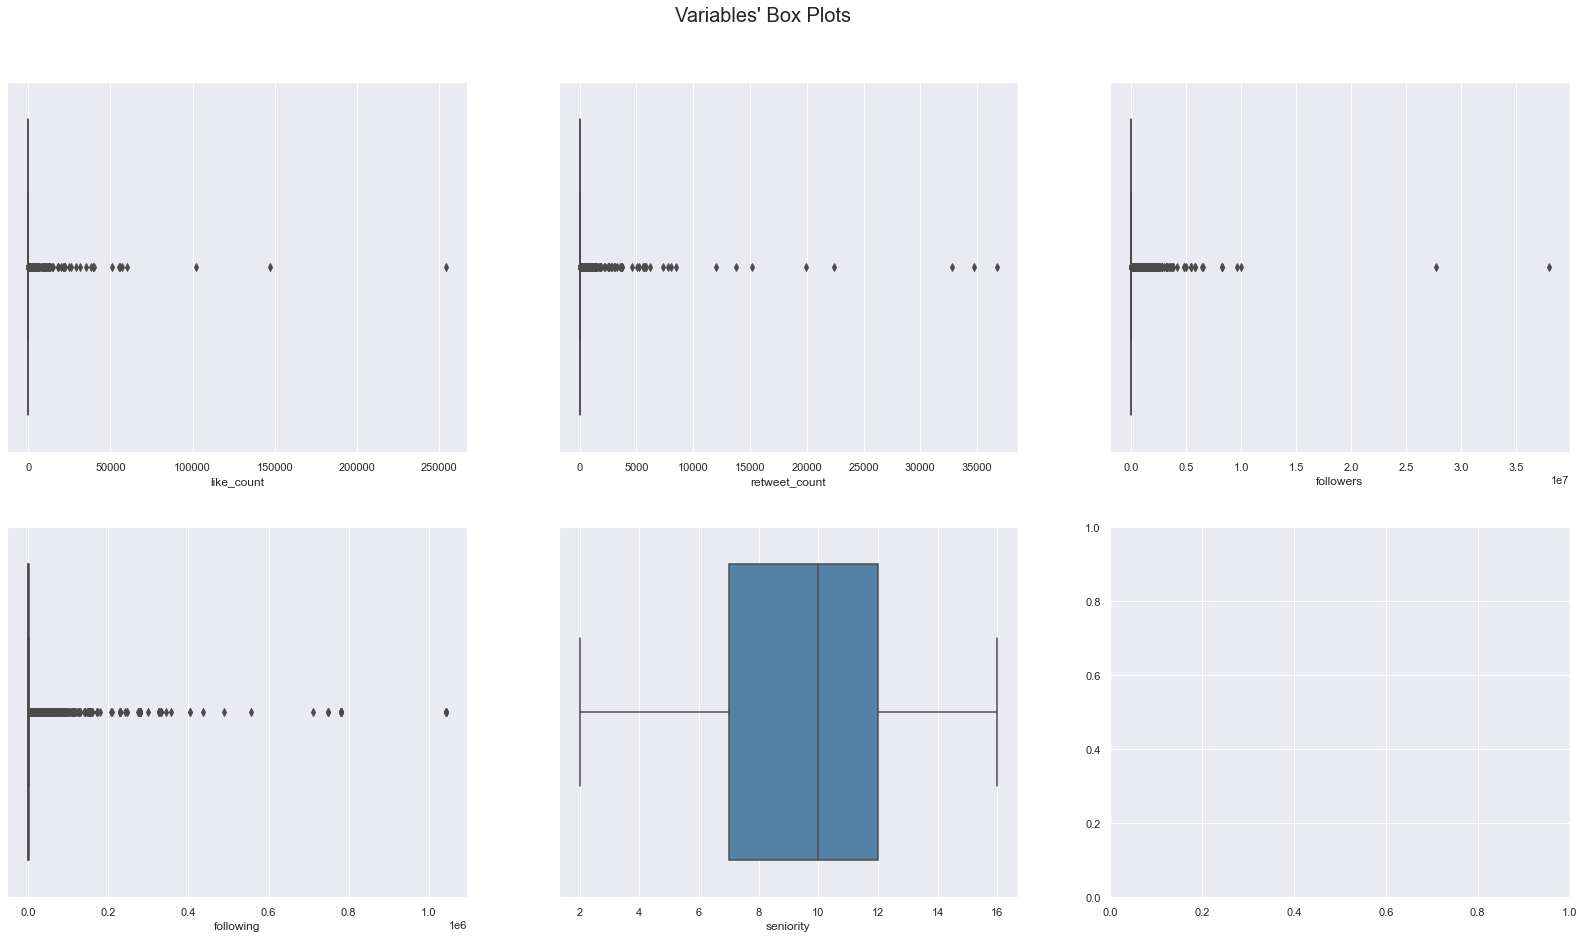

In [47]:
boxplots(df, var_outliers_imp)

In [48]:
outliers_filter = (((df['followers'] < 10000) & (df['following'] < 70000)) & ((df['retweet_count'] < 100) & (df['like_count'] < 500) & (df['seniority'] < 17)))
outliers_removal(df, outliers_filter)

Percentage of data kept after removing outliers: 94.8 %
Percentage of data removed: 5.2035 %
Size after outlier removal: 507187
N. of tweets with atleast 1 retweet: 80159
Percentage of tweets with atleast 1 retweet removed: 14.2116 %


,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,1079904885246705665,I’ll never salt you down 😌,2019-01-01 00:59:22,497001647,0,0,0,0,1468,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,10
1,1,1181478514601672704,I need to go to sleeeeeep,2019-10-08 07:56:43+00:00,497001647,0,0,0,0,1468,...,Tuesday,Morning,2019-41,3,5,10,0,1,0,10
2,2,1079904884445581312,You know who you are; but some of you I’ve fol...,2019-01-01 00:59:22,112542289,2,1,0,0,2969,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,12
3,3,1083000265597485056,Good morning frens. Don’t think about yesterda...,2019-01-09 13:59:19,112542289,5,1,0,0,2969,...,Wednesday,Afternoon,2019-02,0,6,4,0,1,0,12
4,4,1100394993972404224,Have any of you seen that post about the salon...,2019-02-26 13:59:45+00:00,112542289,3,1,0,1,4897,...,Tuesday,Afternoon,2019-09,0,5,3,0,2,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535022,535022,1212131305615511554,It’s taken almost 20 years.... but the boys ap...,2019-12-31 21:59:58+00:00,3160522828,62,3,1,8,5864,...,Tuesday,Night,2019-01,4,5,2,0,2,0,7
535023,535023,1212131306085244928,My boss is boss. https://t.co/aButy11GXA,2019-12-31 21:59:58+00:00,802746211,1,0,0,0,681,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535024,535024,1212131307162988544,Mood: https://t.co/d5iIJatvZO,2019-12-31 21:59:58+00:00,713174863,19,2,0,0,1455,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535025,535025,1212131308010430464,I’m watching Star Wars for the first time.,2019-12-31 21:59:58+00:00,2463021749,0,0,0,1,1171,...,Tuesday,Night,2019-01,4,5,2,0,0,0,8


In [49]:
outliers_filter = (((df['followers'] < 100000) & (df['following'] < 70000)) & ((df['retweet_count'] < 100) & (df['like_count'] < 500) & (df['seniority'] < 17)))
outliers_removal(df, outliers_filter)

Percentage of data kept after removing outliers: 99.44 %
Percentage of data removed: 0.5585 %
Size after outlier removal: 532039
N. of tweets with atleast 1 retweet: 91021
Percentage of tweets with atleast 1 retweet removed: 2.5867 %


,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,1079904885246705665,I’ll never salt you down 😌,2019-01-01 00:59:22,497001647,0,0,0,0,1468,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,10
1,1,1181478514601672704,I need to go to sleeeeeep,2019-10-08 07:56:43+00:00,497001647,0,0,0,0,1468,...,Tuesday,Morning,2019-41,3,5,10,0,1,0,10
2,2,1079904884445581312,You know who you are; but some of you I’ve fol...,2019-01-01 00:59:22,112542289,2,1,0,0,2969,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,12
3,3,1083000265597485056,Good morning frens. Don’t think about yesterda...,2019-01-09 13:59:19,112542289,5,1,0,0,2969,...,Wednesday,Afternoon,2019-02,0,6,4,0,1,0,12
4,4,1100394993972404224,Have any of you seen that post about the salon...,2019-02-26 13:59:45+00:00,112542289,3,1,0,1,4897,...,Tuesday,Afternoon,2019-09,0,5,3,0,2,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535022,535022,1212131305615511554,It’s taken almost 20 years.... but the boys ap...,2019-12-31 21:59:58+00:00,3160522828,62,3,1,8,5864,...,Tuesday,Night,2019-01,4,5,2,0,2,0,7
535023,535023,1212131306085244928,My boss is boss. https://t.co/aButy11GXA,2019-12-31 21:59:58+00:00,802746211,1,0,0,0,681,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535024,535024,1212131307162988544,Mood: https://t.co/d5iIJatvZO,2019-12-31 21:59:58+00:00,713174863,19,2,0,0,1455,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535025,535025,1212131308010430464,I’m watching Star Wars for the first time.,2019-12-31 21:59:58+00:00,2463021749,0,0,0,1,1171,...,Tuesday,Night,2019-01,4,5,2,0,0,0,8


In [50]:
outliers_filter = (((df['followers'] < 100000) & (df['following'] < 30000)) & ((df['retweet_count'] < 100) & (df['like_count'] < 400) & (df['seniority'] < 17)))
outliers_removal(df, outliers_filter)

Percentage of data kept after removing outliers: 99.28 %
Percentage of data removed: 0.7172 %
Size after outlier removal: 531190
N. of tweets with atleast 1 retweet: 90577
Percentage of tweets with atleast 1 retweet removed: 3.0619 %


,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,1079904885246705665,I’ll never salt you down 😌,2019-01-01 00:59:22,497001647,0,0,0,0,1468,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,10
1,1,1181478514601672704,I need to go to sleeeeeep,2019-10-08 07:56:43+00:00,497001647,0,0,0,0,1468,...,Tuesday,Morning,2019-41,3,5,10,0,1,0,10
2,2,1079904884445581312,You know who you are; but some of you I’ve fol...,2019-01-01 00:59:22,112542289,2,1,0,0,2969,...,Tuesday,Middle of the night,2019-01,2,5,4,0,2,0,12
3,3,1083000265597485056,Good morning frens. Don’t think about yesterda...,2019-01-09 13:59:19,112542289,5,1,0,0,2969,...,Wednesday,Afternoon,2019-02,0,6,4,0,1,0,12
4,4,1100394993972404224,Have any of you seen that post about the salon...,2019-02-26 13:59:45+00:00,112542289,3,1,0,1,4897,...,Tuesday,Afternoon,2019-09,0,5,3,0,2,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535022,535022,1212131305615511554,It’s taken almost 20 years.... but the boys ap...,2019-12-31 21:59:58+00:00,3160522828,62,3,1,8,5864,...,Tuesday,Night,2019-01,4,5,2,0,2,0,7
535023,535023,1212131306085244928,My boss is boss. https://t.co/aButy11GXA,2019-12-31 21:59:58+00:00,802746211,1,0,0,0,681,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535024,535024,1212131307162988544,Mood: https://t.co/d5iIJatvZO,2019-12-31 21:59:58+00:00,713174863,19,2,0,0,1455,...,Tuesday,Night,2019-01,4,5,2,0,1,0,9
535025,535025,1212131308010430464,I’m watching Star Wars for the first time.,2019-12-31 21:59:58+00:00,2463021749,0,0,0,1,1171,...,Tuesday,Night,2019-01,4,5,2,0,0,0,8


In [51]:
outliers_filter = (((df['followers'] < 100000) & (df['following'] < 30000)) & ((df['retweet_count'] < 1000) & (df['like_count'] < 400) & (df['seniority'] < 17)))
df = outliers_removal(df, outliers_filter)

Percentage of data kept after removing outliers: 99.3 %
Percentage of data removed: 0.7018 %
Size after outlier removal: 531272
N. of tweets with atleast 1 retweet: 90659
Percentage of tweets with atleast 1 retweet removed: 2.9742 %


## Save the final version of the dataset

In [52]:
year = df.iloc[0]['timestamp'].year
print(year)
location = FINAL_DATASET + str(year) + '.csv'
location_retweets = FINAL_DATASET_RETWEETS_INFO + str(year) + '.csv'
print(location)
print(location_retweets)

2019
../../data/processed_data/tweets_2019.csv
../../data/processed_data/retweets_2019.csv


In [53]:
df.to_csv(location, sep=',', date_format='%Y-%m-%d %H:%M:%S')

In [54]:
df_retweets_info.to_csv(location_retweets, sep=',', date_format='%Y-%m-%d %H:%M:%S')